In [1]:
from npc_sessions import DynamicRoutingSession, get_sessions
import npc_sessions.utils.stim as stim
import npc_sessions.utils as utils
from matplotlib import pyplot as plt
import numpy as np
import datetime
import os
import itertools

In [26]:
def get_audio_latencies(session,stim_type):
    
    if 'task' in stim_type.lower() or 'behavior' in stim_type.lower():
        sel_stim = next(s for s in session.stim_paths if 'DynamicRouting' in s.stem)
    elif 'rf' in stim_type.lower() or 'mapping' in stim_type.lower():
        sel_stim = next(s for s in session.stim_paths if 'RFMapping' in s.stem)

    #get nidaq latencies
    lat_nidaq_env = stim.get_stim_latencies_from_nidaq_recording(
        sel_stim,
        session.sync_path,
        session.ephys_recording_dirs,
        'audio',
        use_envelope=True,
    )

    lat_nidaq_sig = stim.get_stim_latencies_from_nidaq_recording(
        sel_stim,
        session.sync_path,
        session.ephys_recording_dirs,
        'audio',
        use_envelope=False,
    )

    lat_nidaq_sig_list = [y.latency for y in lat_nidaq_sig if y is not None]
    lat_nidaq_env_list = [y.latency for y in lat_nidaq_env if y is not None]

    sound_type_list = [y.name for y in lat_nidaq_sig if y is not None]

    audtridx=[]
    for ii,lat in enumerate(lat_nidaq_sig):
        if lat is not None:
            audtridx.append(ii)

    #get sync latencies
    if session.sync_data.start_time.date() >= datetime.date(year=2023,month=8,day=31):
        sync_sound_on=True
    else:
        sync_sound_on=False

    if sync_sound_on:
        sync_line = stim.get_sync_line_for_stim_onset(
            "audio", session.sync_data.start_time.date()
        )

        lat_sync =  stim.get_stim_latencies_from_sync(
            sel_stim,
            session.sync_path,
            "audio",
            sync_line
        )

        lat_sync_list = [y.latency for y in lat_sync if y is not None]
        audtridx_sync=[]
        for ii,lat in enumerate(lat_sync):
            if lat is not None:
                audtridx_sync.append(ii)

    latency_info = {
        'nidaq_signal':lat_nidaq_sig_list,
        'nidaq_envelope':lat_nidaq_env_list,
        'aud_trial_idx':audtridx,
        'sync_sound_on':sync_sound_on,
        'sound_type':sound_type_list,
    }

    if sync_sound_on:
        latency_info['sync']=lat_sync_list
        latency_info['aud_trial_idx_sync']=audtridx_sync


    return latency_info

def plot_audio_latencies(session,latency_info):

    latency_flags=[]
    if np.sum(np.array(latency_info['nidaq_signal'])<0)>0:
        latency_flags.append('signal xcorr')
    if np.sum(np.array(latency_info['nidaq_envelope'])<0)>0:
        latency_flags.append('envelope xcorr')
    if latency_info['sync_sound_on']==True:
        if np.sum(np.array(latency_info['sync'])<0)>0:
            latency_flags.append('sync')

    xbins=np.arange(-0.15,0.15,0.001)
    fig,ax=plt.subplots(2,1)
    ax[0].plot(latency_info['aud_trial_idx'],latency_info['nidaq_signal'],'.',alpha=0.5)
    ax[0].plot(latency_info['aud_trial_idx'],latency_info['nidaq_envelope'],'.',alpha=0.5)

    ax[0].set_xlabel('trial number')
    ax[0].set_ylabel('audio latency (s)')

    ax[1].hist(latency_info['nidaq_signal'],bins=xbins,alpha=0.5)
    ax[1].hist(latency_info['nidaq_envelope'],bins=xbins,alpha=0.5)

    ax[1].set_xlabel('audio latency (s)')
    ax[1].set_ylabel('trial count')
    ax[1].legend(['signal','envelope'])

    if latency_info['sync_sound_on']==True:
        ax[0].plot(latency_info['aud_trial_idx_sync'],latency_info['sync'],'.',alpha=0.5)
        ax[1].hist(latency_info['sync'],bins=xbins,alpha=0.5)
        ax[1].legend(['signal','envelope','sync'])

    if 'templeton' in session.task_version:
        figtitle='Audio latency by alignment method: '+session.id+' (templeton)'
    else:
        figtitle='Audio latency by alignment method: '+session.id+' (DR)'

    latency_warning='Warning! negative latencies in: '
    if len(latency_flags)>0:
        for flag in latency_flags:
            latency_warning=latency_warning+flag+', '
        ax[0].set_title(latency_warning[:-2])

    fig.suptitle(figtitle)
    fig.tight_layout()

    return fig

def plot_tone_vs_AMnoise(session, latency_info):
    #compare tones vs. AM noise
    tone_idx=np.asarray(latency_info['sound_type'])=='tone'
    AMnoise_idx=np.asarray(latency_info['sound_type'])=='AM_noise'

    aud_trial_idx=np.asarray(latency_info['aud_trial_idx'])
    nidaq_signal=np.asarray(latency_info['nidaq_signal'])
    nidaq_envelope=np.asarray(latency_info['nidaq_envelope'])
    if latency_info['sync_sound_on']==True:
        sync=np.asarray(latency_info['sync'])
        aud_trial_idx_sync=np.asarray(latency_info['aud_trial_idx_sync'])

    xbins=np.arange(-0.15,0.15,0.001)
    fig,ax=plt.subplots(2,2,figsize=(8,5))

    idxs=[tone_idx,AMnoise_idx]
    idx_labels=['tone','AM noise']

    for xx,idx in enumerate(idxs):

        latency_flags=[]
        if np.sum(np.array(nidaq_signal[idx])<0)>0:
            latency_flags.append('signal xcorr')
        if np.sum(np.array(nidaq_envelope[idx])<0)>0:
            latency_flags.append('envelope xcorr')
        if latency_info['sync_sound_on']==True:
            if np.sum(np.array(sync[idx])<0)>0:
                latency_flags.append('sync')

        ax[0,xx].plot(aud_trial_idx[idx],nidaq_signal[idx],'.',alpha=0.5)
        ax[0,xx].plot(aud_trial_idx[idx],nidaq_envelope[idx],'.',alpha=0.5)

        ax[0,xx].set_xlabel('trial number')
        ax[0,xx].set_ylabel('audio latency (s)')

        ax[1,xx].hist(nidaq_signal[idx],bins=xbins,alpha=0.5)
        ax[1,xx].hist(nidaq_envelope[idx],bins=xbins,alpha=0.5)

        ax[1,xx].set_xlabel('audio latency (s)')
        ax[1,xx].set_ylabel('trial count')
        ax[1,xx].legend(['signal','envelope'])

        if latency_info['sync_sound_on']==True:
            ax[0,xx].plot(aud_trial_idx_sync[idx],sync[idx],'.',alpha=0.5)
            ax[1,xx].hist(sync[idx],bins=xbins,alpha=0.5)
            ax[1,xx].legend(['signal','envelope','sync'])

        latency_warning=idx_labels[xx]+': neg lats in: '
        if len(latency_flags)>0:
            for flag in latency_flags:
                latency_warning=latency_warning+flag+', '
            ax[0,xx].set_title(latency_warning[:-2])
        else:
            ax[0,xx].set_title(idx_labels[xx])

    if 'templeton' in session.task_version:
        figtitle='Comp tone vs. AM noise latency: '+session.id+' RFMapping (templeton)'
    else:
        figtitle='Comp tone vs. AM noise latency: '+session.id+' RFMapping (DR)'

    fig.suptitle(figtitle)
    fig.tight_layout()

    return fig


In [3]:
# session = DynamicRoutingSession('670248_2023-08-01') #templeton session, 
# session = DynamicRoutingSession('670181_2023-07-18') #templeton session, 
session = DynamicRoutingSession('668755_2023-08-31') #DR session, has sound on sync

takes 5-10 min per experiment

c:\Users\ethan.mcbride\Code\npc_sessions\.venv\Lib\site-packages\numcodecs\abc.py:107: UserWarning: Multi-threading is supported for wavpack version>=5.6.4, but current version is 5.5.0. Parallel decoding will not be available.
  return cls(**config)


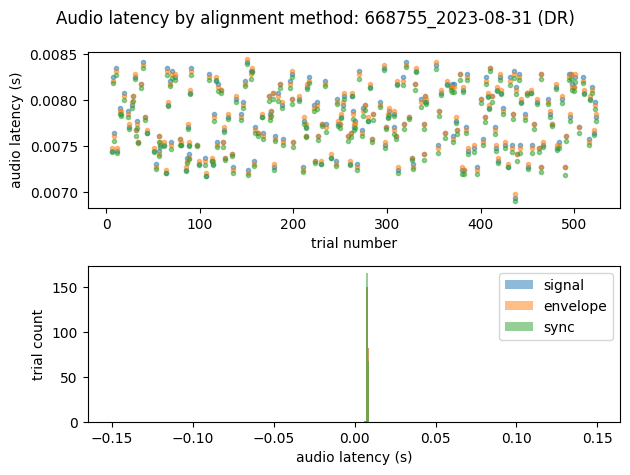

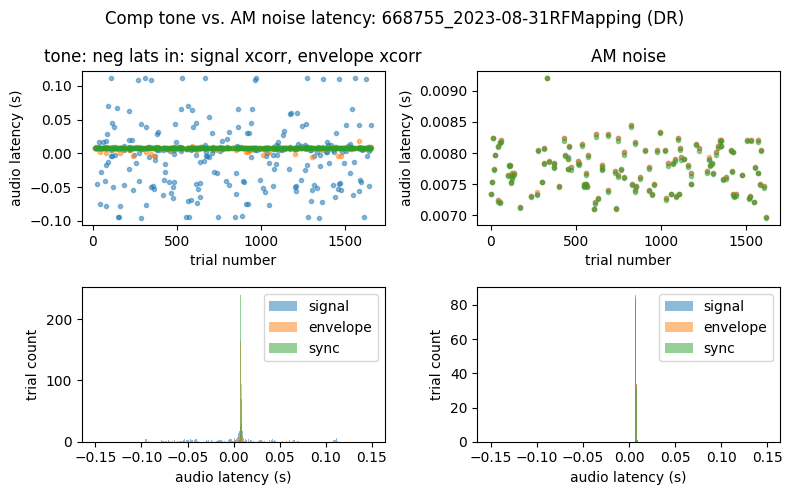

In [27]:
#plot single session - task trials
latency_info = get_audio_latencies(session,'task')
fig = plot_audio_latencies(session,latency_info)




In [ ]:
#comp tone and AM noise w/ RF mapping
latency_info_rf = get_audio_latencies(session,'rf')
fig_rf = plot_tone_vs_AMnoise(session,latency_info_rf)

In [20]:
latency_info.keys()

dict_keys(['nidaq_signal', 'nidaq_envelope', 'aud_trial_idx', 'sync_sound_on', 'sound_type', 'sync', 'aud_trial_idx_sync'])

In [ ]:
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR_QC_stuff\audio_latency"
all_latencies={}
all_latencies_rf={}
except_list={}
for session in get_sessions():

    try:
        #task stim
        latency_info = get_audio_latencies(session,'task')
        fig = plot_audio_latencies(session,latency_info)

        savepath=os.path.join(savepath,session.id+"_audio_latency.png")
        fig.savefig(savepath, dpi=300, format=None, metadata=None,
                    bbox_inches=None, pad_inches=0.1,
                    facecolor='auto', edgecolor='auto',
                    backend=None,
                )
        
        all_latencies[session.id]=latency_info

        #rf stim
        latency_info_rf = get_audio_latencies(session,'rf')
        fig_rf = plot_tone_vs_AMnoise(session,latency_info_rf)

        savepath=os.path.join(savepath,session.id+"_tone_vs_AMnoise_RF.png")
        fig.savefig(savepath, dpi=300, format=None, metadata=None,
                    bbox_inches=None, pad_inches=0.1,
                    facecolor='auto', edgecolor='auto',
                    backend=None,
                )
        
        all_latencies_rf[session.id]=latency_info_rf

    except Exception as e:
        except_list[session.id]=e

        continue

np.save(os.path.join(savepath,'all_latencies.npy'),all_latencies,allow_pickle=True)
np.save(os.path.join(savepath,'all_latencies_rf.npy'),all_latencies_rf,allow_pickle=True)
np.save(os.path.join(savepath,'except_list.npy'),except_list,allow_pickle=True)
